In [1]:
# Import Cell
import torch
from torch.utils.data import Dataset
import glob
import os
from PIL import Image, ImageDraw
import cv2
from torchvision import transforms
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from eval_helper import calculate_mAP
from torchvision import models
from torch.utils.data import random_split
from cocodataset import Compose, ToTensor, CocoDataset
import sys
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def train_one_epoch(model, optimizer, loader, device, epoch, lr_scheduler):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        # Skip batches with None
        if images is None or targets is None or any(img is None for img in images) or any(tar is None for tar in targets):
            continue

        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step()
        
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))


In [3]:
def evaluate(val_loader, model, device, label_threshold=0.8, iou_threshold=0.5):
    device1 = torch.device('cpu')
    model.to(device)
    model.eval()

    det_boxes = []
    det_labels = []
    det_scores = []
    true_boxes = []
    true_labels = []
    true_difficulties = []
    
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            if images is None or targets is None or any(img is None for img in images) or any(tar is None for tar in targets):
                continue

            images = list(image.to(device) for image in images)
            predictions = model(images)
            for i in range(len(predictions)):
                pred = predictions[i]
                det_boxes.append(pred['boxes'][pred['scores'] > label_threshold].to(device1))
                det_labels.append(pred['labels'][pred['scores'] > label_threshold].to(device1))
                det_scores.append(torch.tensor([sc for sc in pred['scores'].tolist() if sc > label_threshold], dtype=torch.float32).to(device1))
                true_boxes.append(targets[i]['boxes'].to(device1))
                true_labels.append(targets[i]['labels'].to(device1))
                true_difficulties.append(torch.zeros(len(targets[i]['labels'])).to(device1))   
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, device1, iou_threshold)
    return APs, mAP

In [4]:
def get_model():
    n_classes = 2
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

def get_data_loader(img_folder, ann_file, train_flag=True):
    transforms = Compose([ToTensor()])
    dataset = CocoDataset(img_folder, ann_file, transforms=transforms)
    batch_size = 4
    workers = 4
    if not train_flag:
        workers = 1 

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_flag, num_workers=workers,
                                                pin_memory=True, collate_fn=collate_fn)
    return data_loader


In [5]:
def main(train_img_folder, train_ann_file, val_img_folder, val_ann_file):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    n_gpu = torch.cuda.device_count()

    model = get_model()
    train_loader = get_data_loader(train_img_folder, train_ann_file, train_flag=True)
    val_loader = get_data_loader(val_img_folder, val_ann_file, train_flag=False)

    print("Number of GPUs: " + str(n_gpu))

    train_losses = []
    n_epochs = 3
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = None
    loss_list = []

    for epoch in range(n_epochs + 1):
        train_one_epoch(model, optimizer, train_loader, device, epoch, scheduler)
        print(evaluate(val_loader, model, device))
        model.eval()
        torch.save(model.state_dict(), 'model_epoch' + str(epoch) + '.pth')

if __name__ == "__main__":
    if len(sys.argv) != 5:
        print("Usage: python script_name.py <train_img_folder> <train_ann_file> <val_img_folder> <val_ann_file>")
    else:
        main(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4])


Usage: python script_name.py <train_img_folder> <train_ann_file> <val_img_folder> <val_ann_file>


In [6]:
import os
from pycocotools.coco import COCO
from tqdm import tqdm

def check_image_files(img_folder, ann_file):
    coco = COCO(ann_file)
    img_ids = coco.getImgIds()
    missing_images = []
    missing_image_ids = []

    for img_id in tqdm(img_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_file = os.path.join(img_folder, img_info['file_name'])
        if not os.path.exists(img_file):
            print(f"Image not found: {img_file}")
            missing_images.append(img_file)
            missing_image_ids.append(img_id)
    
    if not missing_images:
        print("All images are found.")
    else:
        print(f"Total missing images: {len(missing_images)}")
    return missing_images, missing_image_ids

train_img_folder = "./test2_building_dataset/train/train_img"
train_ann_file = "./test2_building_dataset/train/_annotations.coco.json"
val_img_folder = "./test2_building_dataset/valid/valid_img"
val_ann_file = "./test2_building_dataset/valid/_annotations.coco.json"

print("Checking training images:")
img_not_found, img_ids_not_found = check_image_files(train_img_folder, train_ann_file)
print(img_not_found)


Checking training images:
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|███████████████████████████████████| 1171/1171 [00:00<00:00, 293892.41it/s]

All images are found.
[]


In [7]:
import json

# Delete the annotation whose no mapped image
def delete_annotations(ann_file, img_ids_not_found):
    with open(ann_file, 'r') as f:
        annotations = json.load(f)
    
    annotations['images'] = [img for img in annotations['images'] if img['id'] not in img_ids_not_found]
    annotations['annotations'] = [ann for ann in annotations['annotations'] if ann['image_id'] not in img_ids_not_found]

    with open(ann_file, 'w') as f:
        json.dump(annotations, f, indent=4)
    
    print(f"Updated annotations saved to {ann_file}")

delete_annotations(train_ann_file, img_ids_not_found)


Updated annotations saved to ./test2_building_dataset/train/_annotations.coco.json


Checking training images:


***Image not found: ./building_structures.v1i.coco/train/images/dunrobin-zamok-sazerlend-shotlandiya-alba-velikobritaniya-zamok-park-solnce-svet-nebo-oblaka-zelen-trava-gazon-kusty-derevya-fontan-priroda-pejzazh_jpg.rf.3831b7c324e2aeefdf0a8e12abeaa82d.jpg***

Total missing images: 1

Checking validation images:

All images are found.


In [8]:
train_img_folder = "./test2_building_dataset/train/train_img"
train_ann_file = "./test2_building_dataset/train/_annotations.coco.json"
val_img_folder = "./test2_building_dataset/valid/valid_img"
val_ann_file = "./test2_building_dataset/valid/_annotations.coco.json"
main(train_img_folder, train_ann_file, val_img_folder, val_ann_file)


/home/pthapa4/Downloads/yes/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pthapa4/Downloads/yes/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of GPUs: 1


  0%|                                                   | 0/293 [00:00<?, ?it/s]/tmp/ipykernel_81621/1928987733.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
100%|█████████████████████████████████████████| 293/293 [00:34<00:00,  8.53it/s]


Epoch 0, lr: 0.000100, loss: 0.158911, loss_classifier: 0.057643, loss_box: 0.084408, loss_rpn_box: 0.006152, loss_object: 0.010709


100%|███████████████████████████████████████████| 27/27 [00:01<00:00, 18.41it/s]


({'1': 0.8898378610610962, '2': 0.0, '3': 0.0, '4': 0.0}, 0.22245946526527405)


100%|█████████████████████████████████████████| 293/293 [00:33<00:00,  8.73it/s]


Epoch 1, lr: 0.000100, loss: 0.124858, loss_classifier: 0.044285, loss_box: 0.069742, loss_rpn_box: 0.005303, loss_object: 0.005529


100%|███████████████████████████████████████████| 27/27 [00:01<00:00, 19.11it/s]


({'1': 0.8985958099365234, '2': 0.0, '3': 0.0, '4': 0.0}, 0.22464895248413086)


100%|█████████████████████████████████████████| 293/293 [00:33<00:00,  8.65it/s]


Epoch 2, lr: 0.000100, loss: 0.111007, loss_classifier: 0.038744, loss_box: 0.063784, loss_rpn_box: 0.004602, loss_object: 0.003876


100%|███████████████████████████████████████████| 27/27 [00:01<00:00, 19.59it/s]


({'1': 0.8842718005180359, '2': 0.0, '3': 0.0, '4': 0.0}, 0.22106795012950897)


100%|█████████████████████████████████████████| 293/293 [00:33<00:00,  8.65it/s]


Epoch 3, lr: 0.000100, loss: 0.095637, loss_classifier: 0.032106, loss_box: 0.056616, loss_rpn_box: 0.004132, loss_object: 0.002784


100%|███████████████████████████████████████████| 27/27 [00:01<00:00, 19.32it/s]


({'1': 0.9073916077613831, '2': 0.0, '3': 0.0, '4': 0.0}, 0.22684790194034576)


In [9]:
# Model Eval 
def load_model(checkpoint_path, n_classes=2):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)
    model.load_state_dict(torch.load(checkpoint_path))
    return model


In [10]:


def get_data_loader(img_folder, ann_file, train_flag=True):
    transforms = Compose([ToTensor()])
    dataset = CocoDataset(img_folder, ann_file, transforms=transforms)
    batch_size = 4
    workers = 4
    if not train_flag:
        workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_flag, num_workers=workers,
                                              pin_memory=True, collate_fn=collate_fn)
    return data_loader

def evaluate_models(model_paths, val_img_folder, val_ann_file, device):
    val_loader = get_data_loader(val_img_folder, val_ann_file, train_flag=False)

    for model_path in model_paths:
        print(f"Evaluating model: {model_path}")
        model = load_model(model_path)
        APs, mAP = evaluate(val_loader, model, device)
        print(f"Model: {model_path}, mAP: {mAP}")
        for label, ap in APs.items():
            print(f"Label: {label}, AP: {ap}")

# Example usage
model_paths = ['model_epoch0.pth', 'model_epoch1.pth', 'model_epoch2.pth']
val_img_folder = "./test2_building_dataset/valid/valid_img"
val_ann_file = "./test2_building_dataset/valid/_annotations.coco.json"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

evaluate_models(model_paths, val_img_folder, val_ann_file, device)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Evaluating model: model_epoch0.pth


100%|███████████████████████████████████████████| 27/27 [00:01<00:00, 19.40it/s]


Model: model_epoch0.pth, mAP: 0.22245946526527405
Label: 1, AP: 0.8898378610610962
Label: 2, AP: 0.0
Label: 3, AP: 0.0
Label: 4, AP: 0.0
Evaluating model: model_epoch1.pth


100%|███████████████████████████████████████████| 27/27 [00:01<00:00, 19.82it/s]


Model: model_epoch1.pth, mAP: 0.22464895248413086
Label: 1, AP: 0.8985958099365234
Label: 2, AP: 0.0
Label: 3, AP: 0.0
Label: 4, AP: 0.0
Evaluating model: model_epoch2.pth


100%|███████████████████████████████████████████| 27/27 [00:01<00:00, 19.18it/s]

Model: model_epoch2.pth, mAP: 0.22106795012950897
Label: 1, AP: 0.8842718005180359
Label: 2, AP: 0.0
Label: 3, AP: 0.0
Label: 4, AP: 0.0


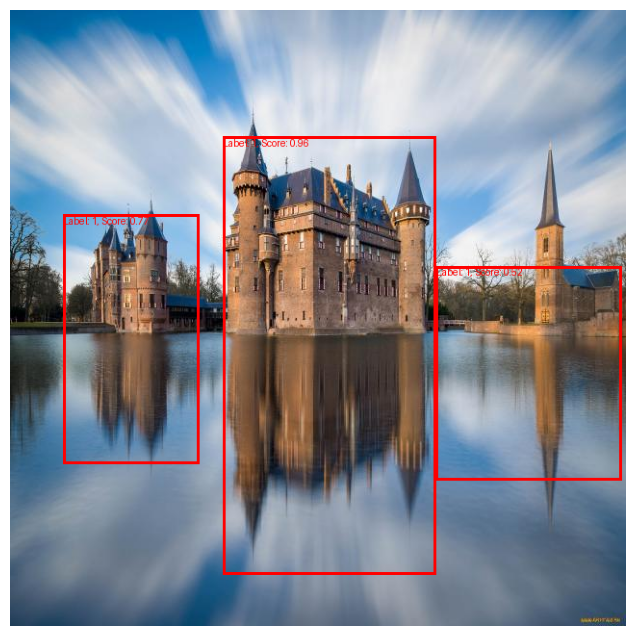

In [25]:
# Function to load and transform the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Function to draw bounding boxes on the image
def draw_boxes(image_path, boxes, labels, scores, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=3)
            draw.text((box[0], box[1]), f"Label: {label}, Score: {score:.2f}", fill="red")
    return image

# Function to make predictions and draw bounding boxes
def predict_and_draw(model, device, image_path, threshold=0.5):
    model.eval()
    model.to(device)

    # Load and transform the image
    image_tensor = load_image(image_path).to(device)

    # Make predictions
    with torch.no_grad():
        predictions = model(image_tensor)

    # Get boxes, labels, and scores
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Draw bounding boxes on the image
    image_with_boxes = draw_boxes(image_path, boxes, labels, scores, threshold)
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()

# Example usage
model_path = 'model_epoch0.pth'
image_path = './building_structures.v1i.coco/valid/images/2048x1365_915257_-www-ArtFile-ru-_jpg.rf.7ba5fcc6756d006ae4221490e010985d.jpg'  # Replace with your image path

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Load the model
model = load_model(model_path)
predict_and_draw(model, device, image_path)

In [12]:
# Image shape 
image_data = cv2.imread(image_path)
print(f"Shape of the image {image_data.shape}")

Shape of the image (640, 640, 3)


In [ ]:
def run_inference(model, image_path, output_folder, confidence_threshold=0.5):

    # Check if GPU is available and move model to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    image = Image.open(image_path).convert("RGB")
    p_image = r_preprocess(image) # apply model specific pre-process from above cell
    image_tensor = p_image.unsqueeze(0)

    model.eval()

    with torch.no_grad():
        predictions = model(image_tensor)

    # Interpret the results
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    
    # Filter predictions based on confidence threshold
    mask = [(score > confidence_threshold and label.item() in coco_to_selected) 
                     for score, label in zip(scores, labels)] 
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]


    # Prepare data for JSON
    results = []
    for box, label, score in zip(boxes, labels, scores):
        results.append({
            'box': box.tolist(),
            'label': coco_to_selected.get(int(label), 'Unknown'),
            'score': float(score)
    })
        
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Save bounding box data to JSON file in the output folder
    base_name = os.path.basename(image_path)
    json_path = os.path.join(output_folder, os.path.splitext(base_name)[0] + ".json")
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)

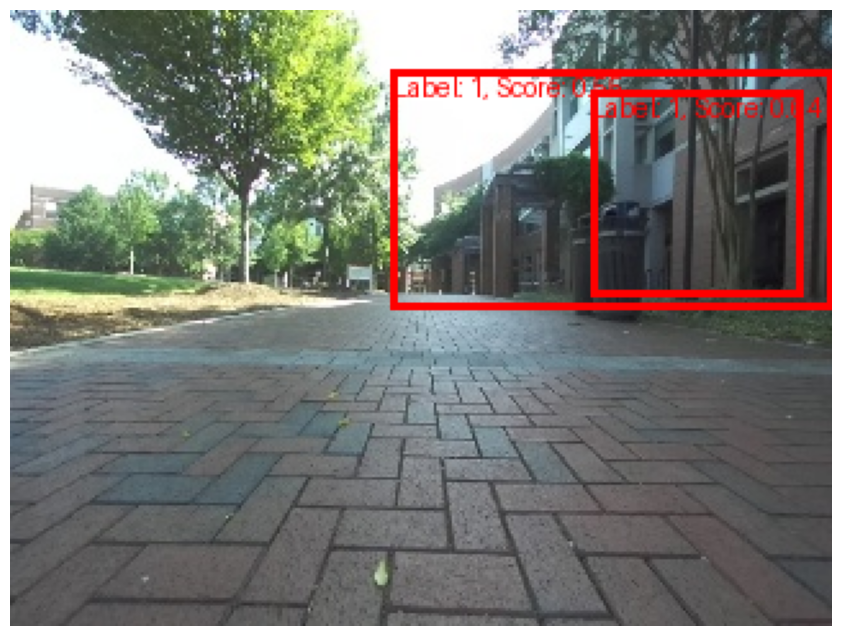

In [29]:
test_image_path = "../DataSetup/resized_dataset/Train/09_50_00.jpg"
predict_and_draw(model, device, test_image_path)